# Truncated Distribution Generator

Generate samples from common distributions truncated with lower and upper bounds

[Overleaf paper](https://www.overleaf.com/6325975793zxxhznfsvcgc)

[PyRo](https://pyro.ai/)

VI with 
- Mean Field
- Stein Method

Generate TD for 
- Gaussian 
- Student (T)

In [1]:
%%capture
!pip install qmcpy --quiet
from qmcpy import *
from numpy import *
from numpy.linalg import inv
from scipy import stats
from matplotlib import pyplot
# plot fonts sizes
pyplot.rc('font', size=16)
pyplot.rc('axes', titlesize=16, labelsize=16)
pyplot.rc('xtick', labelsize=16)
pyplot.rc('ytick', labelsize=16)
pyplot.rc('legend', fontsize=16)
pyplot.rc('figure', titlesize=16)

In [2]:
def scat_plot(x,ax,xlim,ylim,s,color,title,pltbds=False,lb=None,ub=None):
    ax.scatter(x[:,0],x[:,1],s=s,color=color)
    ax.set_xlim(xlim);ax.set_xticks(xlim);ax.set_xlabel('$x_{i,1}$')
    ax.set_ylim(ylim);ax.set_yticks(ylim);ax.set_ylabel('$x_{i,2}$')
    ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    ax.set_title(title)
    if pltbds:
        ax.axhline(y=lb[1], color='k', linestyle='--')
        ax.axhline(y=ub[1], color='k', linestyle='--')
        ax.axvline(x=lb[0], color='k', linestyle='--')
        ax.axvline(x=ub[0], color='k', linestyle='--')

In [3]:
def trunc_gen(x_stdu, lb, ub, distrib, independent=True, **params):
    """
    Transform samples mimicking a standard uniform to mimic a truncated distribution
    
    Args:
        x_stdu (numpy.ndarray): n samples x d dimensional array of samples
        lb (numpy.ndarray): length d lower bound vector
        ub (numpy.ndarray): length d upper bound vector
        distrib (scipy.stats module): a distribution from scipy.stats (i.e.norm,t) 
            that has `cdf` and `ppf` (inverse cdf) functions
        independent (bool): sample dimensions are independent? 
        **params (dict): keyword arguments (parameters) to pass to into `distrib.cdf` and `distrib.ppf`
            
    Return:
        numpy.ndarray: n samples by d dimension array of samples mimicking the truncated distribution
    """
    cdf = distrib.cdf
    invcdf = distrib.ppf
    if independent:
        x_trunc = zeros(x_stdu.shape,dtype=double)
        for j in range(x_trunc.shape[1]):
            params_j = {param:val[j] for param,val in params.items()}
            cdflb = cdf(lb[j],**params_j)
            cdfub = cdf(ub[j],**params_j)
            x_trunc[:,j] = invcdf((cdfub-cdflb)*x_stdu[:,j]+cdflb,**params_j)
        return x_trunc
    else:
        msg = '''
        `trunc_gen` currenly only supports generating samples from 
        distributions with independent dimensions.
        '''
        raise Exception(msg)
        return -1

In [4]:
d = 2
n = 2**8

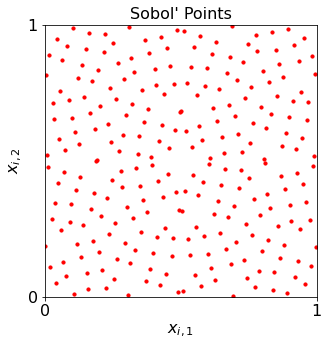

In [5]:
s = Sobol(d,seed=7)
u = s.gen_samples(n)
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(5,5))
scat_plot(u,ax,[0,1],[0,1],s=10,color='r',title="Sobol' Points")

### Generating from Guassian and Student with $\mu=0$ and $\Sigma=1$

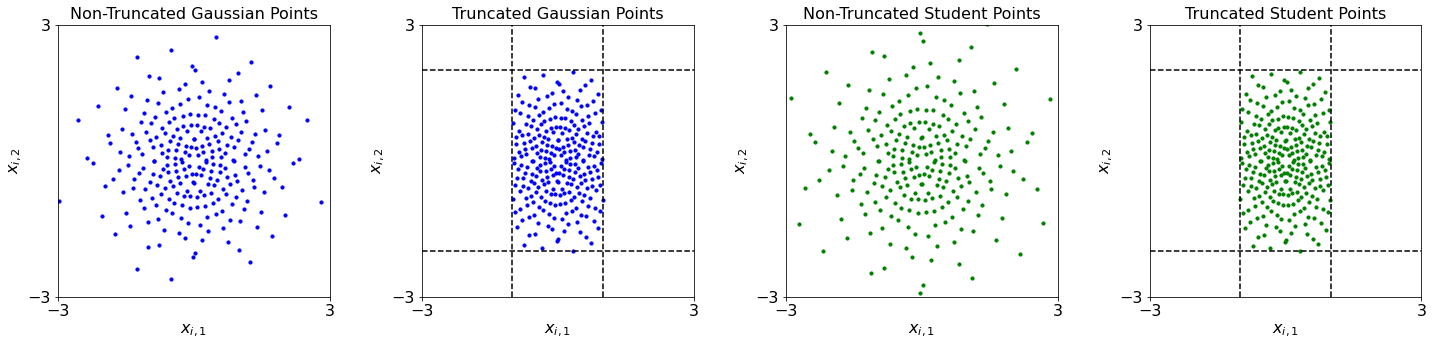

In [6]:
# parameters
trunc_lb = array([-1,-2])
trunc_ub = array([1,2])
# points
g = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.norm)
gt = trunc_gen(u,trunc_lb,trunc_ub,stats.norm)
t = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.t,df=tile(5,d))
tt = trunc_gen(u,trunc_lb,trunc_ub,stats.t,df=tile(5,d))
# plots
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(25,5))
scat_plot(g,ax[0],[-3,3],[-3,3],s=10,color='b',title="Non-Truncated Gaussian Points")
scat_plot(gt,ax[1],[-3,3],[-3,3],s=10,color='b',title="Truncated Gaussian Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)
scat_plot(t,ax[2],[-3,3],[-3,3],s=10,color='g',title="Non-Truncated Student Points")
scat_plot(tt,ax[3],[-3,3],[-3,3],s=10,color='g',title="Truncated Student Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)

### Generating from Gaussian and Student with $\mu=[1,2]$ and $\Sigma=\text{Diag}([1,16])$

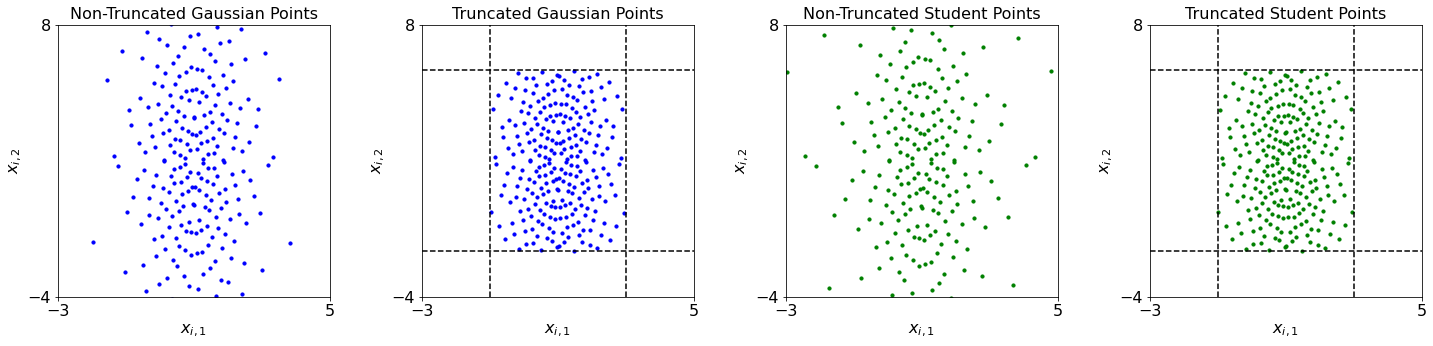

In [7]:
# parameters
mu = array([1,2])
Sigma = array([1,16])
trunc_lb = [-1,-2]
trunc_ub = [3,6]
# points
g = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.norm,loc=mu,scale=sqrt(Sigma))
gt = trunc_gen(u,trunc_lb,trunc_ub,stats.norm,loc=mu,scale=sqrt(Sigma))
t = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.t,df=tile(5,d),loc=mu,scale=sqrt(Sigma))
tt = trunc_gen(u,trunc_lb,trunc_ub,stats.t,df=tile(5,d),loc=mu,scale=sqrt(Sigma))
# plots
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(25,5))
scat_plot(g,ax[0],[-3,5],[-4,8],s=10,color='b',title="Non-Truncated Gaussian Points")
scat_plot(gt,ax[1],[-3,5],[-4,8],s=10,color='b',title="Truncated Gaussian Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)
scat_plot(t,ax[2],[-3,5],[-4,8],s=10,color='g',title="Non-Truncated Student Points")
scat_plot(tt,ax[3],[-3,5],[-4,8],s=10,color='g',title="Truncated Student Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)

# Stein Method

$\newcommand{\bs}[1]{\boldsymbol{#1}}$
Based on the paper: [Stein Variational Gradient Descent: A General Purpose Bayesian Inference Algorithm](https://arxiv.org/abs/1608.04471). 

Algorithm 1 of the above paper wants us to compute:$$\hat{\phi}^*(\bs{z})=\frac{1}{n}\sum_{i=1}^n\left[k(\bs{x}_i,\bs{z})\nabla_{\bs{x}_i}\log(p(\bs{x}_i))+\nabla_{\bs{x}_i} k(\bs{x}_i,\bs{z})\right]$$

Assume we are using the [RBF kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)
$$k(\bs{x},\bs{z})=\exp(-\lVert \bs{z}-\bs{x} \rVert^2 /h)$$
with gradient 
$$\nabla_{\bs{x}}k(\bs{x},\bs{z})=\frac{2}{h}k(\bs{x},\bs{z})\sum_{i=1}^n (\bs{z}-\bs{x})$$

Also assume we want to generate from a truncated multi-variate Gaussian. Letting C be a normalizaiton constant, $\bs{L},\bs{U}$ lower and upper bounds respectively, and $\chi$ the indicator function, then the truncated density is  
$$p(\bs{x}|\bs{\mu},\bs{\Sigma},\bs{L},\bs{U})=C(2\pi)^{-d/2}\det(\bs{\Sigma})^{-1/2}\exp(-(\bs{x}-\bs{\mu})^T\bs{\Sigma}^{-1}(\bs{x}-\bs{\mu})/2)\chi_{(\bs{L},\bs{U})}(\bs{x}),$$
the $\log$ density is
$$\log(p(\bs{x}|\bs{\mu},\bs{\Sigma},\bs{L},\bs{U}))=\left(log(C)-\frac{d}{2}\log(2\pi)-\frac{1}{2}\log(\det(\bs{\Sigma})) - \frac{1}{2}(\bs{x}-\bs{\mu})^T\bs{\Sigma}^{-1}(\bs{x}-\bs{\mu})\right)\chi_{(\bs{L},\bs{U})},$$
and the gradient of the log density is 
$$\nabla_{\bs{x_j}} \log(p(\bs{x}|\bs{\mu},\bs{\Sigma},\bs{L},\bs{U})) = \left(\bs{\mu}^T\bs{\Sigma}^{-1} -\bs{x}^T\bs{\Sigma}^{-1}\right)\chi_{(\bs{L},\bs{U})}.$$

We can then update the particles such that
$$x \leftarrow x+\epsilon\hat{\phi}^*(\bs{x})$$

In [11]:
class GTGS(object):
    """ Gaussian Truncated Distribution Generator by Stein Method"""
    def __init__(self, n, d, mu, Sigma, L, U, epsilon, seed=None):
        """
        Args:
            n (int): number of samples
            d (int): dimension
            mu (ndarray): length d vector of means
            Sigma (ndarray): d x d symmetric positive definite covariance matrix
            L (ndarray): length d vector of lower bounds
            U (ndarray): length d vector of upper bounds
            epsilon (ndarray): step size
            seed (int): seed for reproducibility
        """
        self.n = n
        self.d = d
        self.mu = mu.reshape((-1,1))
        self.Sigma_norm = Sigma.max() # normalization factor
        self.Sigma = Sigma/self.Sigma_norm
        self.B = (vstack((L.flatten(),U.flatten()))-self.mu.T)/sqrt(self.Sigma_norm) # 2 x d array of bounds
        self.epsilon = epsilon
        ss = Sobol(d,seed=seed).gen_samples(self.n) # Sobol' samples from QMCPy. Could be replaced with IID samples
        x_init = trunc_gen(
            x_stdu = ss,
            lb = self.B[0,:],
            ub = self.B[1,:],
            distrib = stats.norm,
            independent = True,
            loc = zeros(self.d),
            scale = sqrt(self.Sigma.diagonal()))
        self.x_init = x_init
        self.x = x_init
        self.h = 5
    def k_rbf(self, x, z): 
        """
        RBF Kernel
        
        Args:
            x (ndarray): n x d array of current samples
            z (ndarray): n x d array of update samples
        
        Return: 
            ndarray: n x n array of samples.
                - ndarray_{i,j} = k(x_i,z_j). 
                - For RBF Kernel the ndarray is symmetric
                - For RBF Kernel the diagnol is 1.
        """
        t = zeros((self.n,self.n),dtype=float)
        for i in range(self.n):
            for j in range(i):
                t[i,j] = exp(((z[j,:]-x[i,:])**2).sum()/self.h)
        t += t.T
        t += ones(self.n)
        return t
    def dk_rbf(self, x, z):
        """
        Derivitive of RBF Kernel
        
        Args:
            x (ndarray): current samples
            z (ndarray): n x d array of update samples
        Return: 
            ndarray: n x n array of samples.
                - ndarray_{i,j} = d(k(x_i,z_j)) / (d x_i). 
                - For RBF Kernel the ndarray is a skew symmetric
                - For RBF Kernel the diagnol is 0.
        """
        t = zeros((self.n,self.n),dtype=float)
        for i in range(self.n):
            for j in range(self.n):
                t[i,j] = 2*self.k_rbf_curr[i,j]*(z[j,:]-x[i,:]).sum()/self.h
        t -= t.T
        return t
    def dlogpgt(self, x):
        """
        Derivitive of log of probability for truncated Gaussian
        
        Args:
            x (ndarray): n x d array of current samples
        
        Return:
            ndarray: n x d array of derivitives
        """
        valid = (x>self.B[0,:]).all(1)&(x<self.B[1,:]).all(1)
        t = - x@inv(self.Sigma)*valid[:,None]
        return t
    def phiHatStar(self, z):
        """
        Get the update direction.
        
        Args:
            z (ndarray): n x d array of samples to update.
        
        Return:
            ndarray: n x d array of update directions.
        """
        self.k_rbf_curr = self.k_rbf(self.x,z)
        self.dlogpgt_curr = self.dlogpgt(self.x)
        self.dk_rbf_curr = self.dk_rbf(self.x,z)
        t = zeros((self.n,self.d),dtype=float)
        for i in range(self.n):
            t[i,:] = (self.k_rbf_curr[:,i,None]*self.dlogpgt_curr+self.dk_rbf_curr[:,i,None]).mean(0)
        return t
    def get_curr_x(self):
        """
        Get the current samples.
        
        Return: 
            ndarray: n x d array of current samples.
        """
        return self.x*sqrt(self.Sigma_norm)+self.mu.T
    def step(self):
        """
        Step the samples in the update direction. 
        
        Return:
            ndarray: current samples.
        """
        self.x += self.epsilon*self.phiHatStar(self.x)
        return self.get_curr_x()
    def walk(self, steps):
        """
        Take multiple update steps. 
        
        Args:
            steps (int): number of times to call step. 
        
        Return: 
            ndarray: current samples. 
        """
        for i in range(steps):
            self.step()
        return self.get_curr_x()

<ipython-input-11-2312be1cdae0>:51: RuntimeWarning: overflow encountered in exp
  t[i,j] = exp(((z[j,:]-x[i,:])**2).sum()/self.h)
<ipython-input-11-2312be1cdae0>:102: RuntimeWarning: invalid value encountered in multiply
  t[i,:] = (self.k_rbf_curr[:,i,None]*self.dlogpgt_curr+self.dk_rbf_curr[:,i,None]).mean(0)


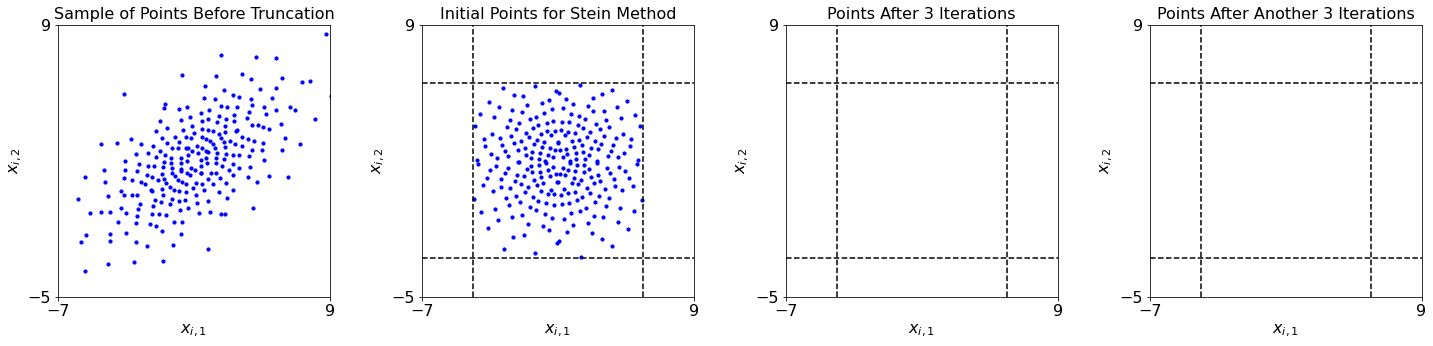

In [13]:
# parameters
mu = array([1,2],dtype=float)
Sigma = array([[9,4],[4,5]],dtype=float)
L = array([-4,-3],dtype=float)
U = array([6,6],dtype=float)
epsilon = 1
walk1 = 3
walk2 = 3
# points
#    1
evals,evecs = linalg.eigh(Sigma)
order = argsort(-evals)
A = dot(evecs[:,order],diag(sqrt(evals[order]))).T
s = Sobol(2,seed=7)
u = s.gen_samples(2**8)
x = stats.norm.ppf(u)@A+mu
#    2
gtgs = GTGS(2**8,2,mu,Sigma,L,U,epsilon,seed=7)
x_init = gtgs.get_curr_x()
#    3
xw1 = gtgs.walk(walk1)
#    4
xw2 = gtgs.walk(walk2)
# plots
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(25,5))
scat_plot(x,ax[0],[-7,9],[-5,9],s=10,color='b',title="Sample of Points Before Truncation")
scat_plot(x_init,ax[1],[-7,9],[-5,9],s=10,color='b',title="Initial Points for Stein Method",pltbds=True,lb=L,ub=U)
scat_plot(xw1,ax[2],[-7,9],[-5,9],s=10,color='b',title="Points After %d Iterations"%walk2,pltbds=True,lb=L,ub=U)
scat_plot(xw2,ax[3],[-7,9],[-5,9],s=10,color='b',title="Points After Another %d Iterations"%walk2,pltbds=True,lb=L,ub=U)